# Homework 3

This skeleton of a notebook should get you started on the first part, in which you will have to mask data and handle outliers.  I have included code to format your plots in a way that I like, and to make a plot to visualize the data.  

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import stats
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Palatino'],'size': 18})
rc('text', usetex=True)
rc('lines', **{'linewidth':3.0})
rc('axes', **{'labelsize':22})

# Part 1: Outlier Treatment and Bootstrapping

This plot shows real data from the *Gaia* satellite.  There are a number of fields in this table, which you can access as shown.  I have printed out the names below the short block of code.  You'll use a few of these; I define them below:

`pmra`: motion across the sky (think $x$ direction), measured in angular units per time.  For example, a star moving at 1 milliarcsecond per year (funny astronomer units) would take 3600 years to travel one degree across the sky.

`pmdec`: same as `pmra`, but in the $y$ direction

`ra`, `dec`: position in the sky (don't worry too much about these)

`parallax`: position shift due to the changing perspective of the Earth through the year.  As the Earth moves around the Sun, the apparent positions of the stars change relative to a background very far away.  The distance is related to parallax by 

${\rm distance~in~parsecs} = 1000/{\rm parallax~in~milliarcseconds}$

The parallaxes here are given in units of milliarcseconds.

`radial_velocity`: velocity of the star towards us (if negative) or away from us (if positive), measured in km/s.

The data set provided has a few thousand stars in a cluster, and a bunch more stars scattered through space that happen to be near the cluster in projection.  Your tasks will be to estimate which stars are members of the cluster, to estimate the cluster's proper motion, distance from Earth, and internal motion, and to put error bars on these estimates.  You can see the cluster in the figure: it's the patch of dark blue points (parallaxes around 2.5 milliarcseconds) at proper motions of around -5 in $x$ and +12 in $y$--a patch in velocity space as represented here.

['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error']


C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


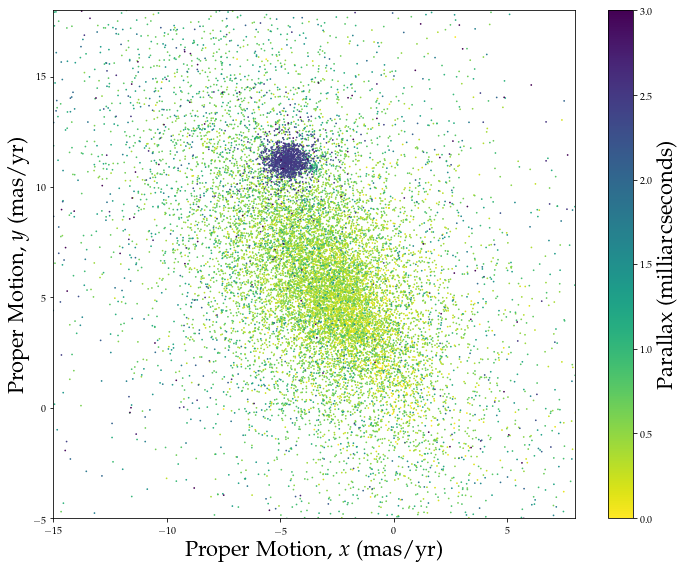

In [2]:
t = fits.open('NGC2516_Gaia.fits.gz')[1].data
print(t.names)
plt.figure(figsize=(10, 8))
plt.scatter(t['pmra'], t['pmdec'], c=t['parallax'], s=0.5, cmap="viridis_r", vmin=0, vmax=3)
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Parallax (milliarcseconds)")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")
plt.tight_layout()
plt.savefig("NGC2516_figure.pdf")

### Part a)

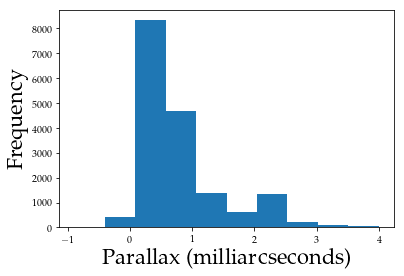

In [3]:
parallax = t['parallax'][t['parallax']<4]
plt.hist(parallax)
plt.xlabel("Parallax (milliarcseconds)")
plt.ylabel("Frequency")
plt.show()

### Part b)

The estimated cluster parallax is: 2.418548114187435, which has standard error: 0.0012012012012012014


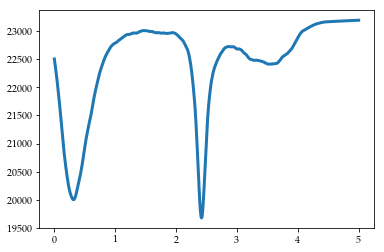

In [4]:
# Chose members to be within an approximate range of parallaxes and found probability of membership from that.
approx_members = parallax[np.logical_and(parallax>=2.2, parallax<=2.6)]
p_good = np.size(approx_members)/np.size(parallax)
p_bad = 1-p_good

parallax_err = t['parallax_error'][t['parallax']<4]

def log_likelihood(mu, parallax_vals, errors):
    mu_bg = 1
    a = 0.5
    
    good = p_good*stats.norm.pdf(parallax_vals, mu, errors)
    bad = p_bad*stats.norm.pdf(parallax_vals, mu_bg, np.sqrt(a**2+errors**2))
    return -np.sum(np.log((good+bad)))

mu_vals = np.linspace(0, 5, 1000)
l = np.zeros(np.size(mu_vals))

for i in range(1000):
    l[i] = log_likelihood(mu_vals[i], parallax, parallax_err)

plt.plot(mu_vals, l)

res = optimize.minimize(log_likelihood, x0=mu_vals[np.argmin(l)], args=(parallax, parallax_err,))
best_fit = res.x[0]
best_fit_likelihood = res.fun

for sig in np.linspace(0, 0.1, 1000):
    loglik_high = log_likelihood(best_fit+sig, parallax, parallax_err)
    if loglik_high > best_fit_likelihood + 0.5:
        break
        
print("The estimated cluster parallax is: " + str(best_fit) + ", which has standard error: " + str(sig))

In [5]:
# Bootstrapping routine for the above mixture model
n_bootstrap = (int)(np.size(parallax)/100)
model = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    i_sample = np.random.randint(0, len(parallax), len(parallax))
    parallax_sample = parallax[i_sample]
    parallax_err_sample = parallax_err[i_sample]
    
    approx_members_sample = parallax_sample[np.logical_and(parallax_sample>=2.2, parallax_sample<=2.6)]
    p_good_sample = np.size(approx_members_sample)/np.size(parallax_sample)
    p_bad_sample = 1-p_good_sample
    
    model[i] = optimize.minimize(log_likelihood, x0=2.4, args=(parallax_sample, parallax_err_sample)).x[0]
    
bootstrap_err = np.std(model)
print("Using a bootstrap resampling method, I obtain a standard error of: " + str(bootstrap_err))

Using a bootstrap resampling method, I obtain a standard error of: 0.002177592497760645


### Part c)

In [74]:
pmra = t['pmra']
pmra_err = t['pmra_error']
pmdec = t['pmdec']
pmdec_err = t['pmdec_error']

# The sizes of the pmra, pmra_err, pmdec, and pmdec_err arrays and those of the parallax and parallax error are unequal. I
# decided to remove the extra elements from the first four arrays, so that they would have the same size.
n = np.size(pmra)-np.size(parallax)
pmra = pmra[:len(pmra)-n]
pmra_err = pmra_err[:len(pmra_err)-n]
pmdec = pmdec[:len(pmdec)-n]
pmdec_err = pmdec_err[:len(pmdec_err)-n]

# In the calculations of the log_likelihood, I still encountered overflow errors despite calculating the log likelihoods,
# indicating that some of the values for the data were far too large to be computed in this fashion. So, with some testing,
# I found the locations of the values which produced overflow errors and removed them, which in essence is the same as
# sigma clipping.
indices = [12875, 15273, 15495, 15839, 16649, 16684, 16755, 16813, 16873, 16911, 16927, 16939, 16952, 16962, 16966, 16997, 
           17010, 17019, 17030, 17040, 17056, 17059, 17063, 17066, 17067, 17095, 17104, 17108, 17114, 17127, 17128, 17133]
pmra_new = np.delete(pmra, indices)
pmra_err_new = np.delete(pmra_err, indices)
pmdec_new = np.delete(pmdec, indices)
pmdec_err_new = np.delete(pmdec_err, indices)
parallax_new = np.delete(parallax, indices)
parallax_err_new = np.delete(parallax_err, indices)

# Calculates the 3D log likelihood according to the given formula
def log_likelihood_3D(p, pmra_vals, pmra_errors, pmdec_vals, pmdec_errors, parallax_vals, parallax_errors):
    A_good = 1/((2*np.pi)**(1.5)*np.sqrt((p[1]**2+pmra_errors**2)*(p[3]**2+pmdec_errors**2)*(parallax_errors**2)))
    gauss_ra_good = np.exp(-0.5*(pmra_vals-p[0])**2/(pmra_errors**2+p[1]**2))
    gauss_dec_good = np.exp(-0.5*(pmdec_vals-p[2])**2/(pmdec_errors**2+p[3]**2))
    gauss_par_good = np.exp(-0.5*(parallax_vals-p[4])**2/parallax_errors**2)
    good = A_good*gauss_ra_good*gauss_dec_good*gauss_par_good
    
    mu_bg = 1
    a = 0.5
    mu_x_bg = 3
    mu_y_bg = -2
    a_x = 1
    a_y = 1
    
    A_bad = 1/((2*np.pi)**(1.5)*np.sqrt((a_x**2+p[1]**2+pmra_errors**2)*(a_y**2+p[3]**2+pmdec_errors**2)*(a**2+parallax_errors**2)))
    gauss_ra_bad = np.exp(-0.5*(pmra_vals-mu_x_bg)**2/(a_x**2+pmra_errors**2+p[1]**2))
    gauss_dec_bad = np.exp(-0.5*(pmdec_vals-mu_y_bg)**2/(a_y**2+pmdec_errors**2+p[3]**2))
    gauss_par_bad = np.exp(-0.5*(parallax_vals-mu_bg)**2/(a**2+parallax_errors**2))
    bad = A_bad*gauss_ra_bad*gauss_dec_bad*gauss_par_bad
    
    return -np.sum(np.log(good+bad))

res = optimize.minimize(log_likelihood_3D, x0=[1, 1, 1, 1, 2.4], 
                        args=(pmra_new, pmra_err_new, pmdec_new, pmdec_err_new, parallax_new, parallax_err_new,)).x
print("The estimated parameter values for the 3D mixture model are: " + str(res))

C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


The estimated parameter values for the 3D mixture model are: [-5.17106619  7.63195462 11.27290635 10.0334663   2.41402931]


In [51]:
# Bootstrapping routine for 3D mixture model. Computation time for the 3D mixture model was a few seconds, so I opted to not
# run the bootstrapping routine ~1000 times which could affect results. Furthermore, the runtime error that was thrown in
# the previous cell was thrown 30 times more in this cell due to the 30 calls to that function here. Since those calls
# did not affect the result, they can be safely ignored.
n_bootstrap = 30
model = []
bootstrap_errs = np.zeros(5)

for i in range(n_bootstrap):
    i_sample = np.random.randint(0, len(parallax_new), len(parallax_new))
    pmra_sample = pmra_new[i_sample]
    pmra_err_sample = pmra_err_new[i_sample]
    pmdec_sample = pmdec_new[i_sample]
    pmdec_err_sample = pmdec_err_new[i_sample]
    parallax_sample = parallax_new[i_sample]
    parallax_err_sample = parallax_err_new[i_sample]
    
    approx_members_sample = parallax_sample[np.logical_and(parallax_sample>=2.2, parallax_sample<=2.6)]
    p_good_sample = np.size(approx_members_sample)/np.size(parallax_sample)
    p_bad_sample = 1-p_good_sample
    
    model.append(optimize.minimize(log_likelihood_3D, x0=[1, 1, 1, 1, 2.4], 
                                 args=(pmra_sample, pmra_err_sample, pmdec_sample, pmdec_err_sample, parallax_sample, 
                                       parallax_err_sample)).x)

model_arr = np.array(model)
for i in range(5):
    bootstrap_errs[i] = np.std(model_arr[:, i])
print("Using a bootstrap resampling method, I obtain standard errors of: " + str(bootstrap_errs) + " for each respective parameter.")

C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: d

C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: d

Using a bootstrap resampling method, I obtain standard errors of: [55.16132813  0.1597464  37.3252331   0.17363717  0.75725266] for each respective parameter.


### Part d)

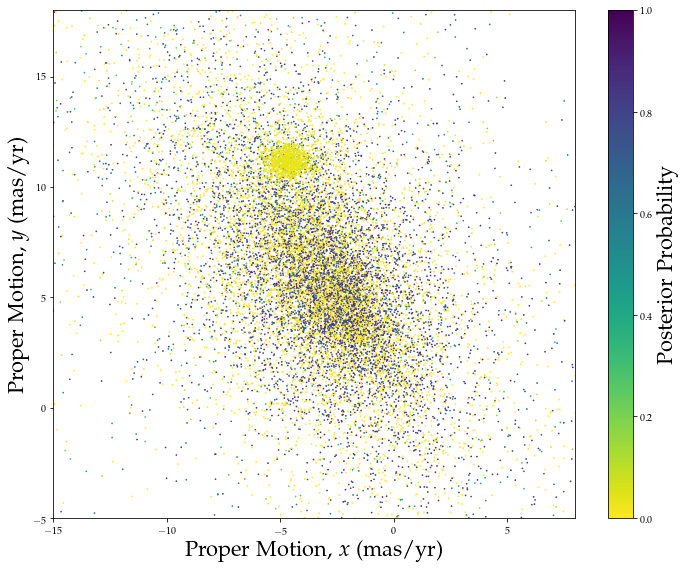

In [76]:
# Bottom three blocks of code are simulating the likelihood of being a member and being a nonmember. Could not use the
# log_likelihood_3D function because of argument and return parameter choices. Also, some values for the member likelihood
# were so small thus causing underflow. I changed it so that those values evaluated to 1 for the final member likelihood. The
# resulting plot does not appear to be entirely correct since the posterior probability of being in the cluster is close to
# zero when it should actually be around 1. Did not have enough time to fix this error.
A_good = 1/((2*np.pi)**(1.5)*np.sqrt((res[1]**2+pmra_err_new**2)*(res[3]**2+pmdec_err_new**2)*(parallax_err_new**2)))
gauss_ra_good = np.exp(-0.5*(pmra_new-res[0])**2/(pmra_err_new**2+res[1]**2))
gauss_dec_good = np.exp(-0.5*(pmdec_new-res[2])**2/(pmdec_err_new**2+res[3]**2))
gauss_par_good = np.exp(-0.5*(parallax_new-res[4])**2/parallax_err_new**2)
good = A_good*gauss_ra_good*gauss_dec_good*gauss_par_good
good[good==0] = np.e
good = np.log(good)

mu_bg = 1
a = 0.5
mu_x_bg = 3
mu_y_bg = -2
a_x = 1
a_y = 1
    
A_bad = 1/((2*np.pi)**(1.5)*np.sqrt((a_x**2+res[1]**2+pmra_err_new**2)*(a_y**2+res[3]**2+pmdec_err_new**2)*(a**2+parallax_err_new**2)))
gauss_ra_bad = np.exp(-0.5*(pmra_new-mu_x_bg)**2/(a_x**2+pmra_err_new**2+res[1]**2))
gauss_dec_bad = np.exp(-0.5*(pmdec_new-mu_y_bg)**2/(a_y**2+pmdec_err_new**2+res[3]**2))
gauss_par_bad = np.exp(-0.5*(parallax_new-mu_bg)**2/(a**2+parallax_err_new**2))
bad = np.log(A_bad*gauss_ra_bad*gauss_dec_bad*gauss_par_bad)

post_good_prob = (1+(p_bad*bad)/(p_good*good))**(-1)

plt.figure(figsize=(10, 8))
plt.scatter(pmra_new, pmdec_new, c=post_good_prob, s=0.5, cmap="viridis_r", vmin=0, vmax=1)
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Posterior Probability")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")
plt.tight_layout()

# Part 2: MCMC

In [68]:
# I used the functions for the model and likelihood from the previous homework solutions in order to get the appropriate
# results.
class Linmodel:
    def __init__(self):
        self.par = None
        self.y = None
        self.cov = None
        self.cov_inv = None

def Tmodel_c1c2c3(c, nu, T, c0=None, data_ivar=None, data_UT=None):
    A = np.ones((len(nu), 6))
    A[:, 0] = 1/nu**2.5
    A[:, 1] = np.log(nu)/nu**2.5
    A[:, 2] = np.log(nu)**2/nu**2.5
    A[:, 3] = 1/nu**4.5
    A[:, 4] = 1/nu**2
    A[:, 5] = np.exp(-np.abs((nu - c[0])/c[1])**(c[2]**2))
        
    result = Linmodel()
    
    # This is the case where c0 is free; we optimize over it.
    if c0 is None:
        Tfit = np.zeros(len(nu))
        b = T
    else:    # In case we want to hold c0 fixed
        Tfit = A[:, 5]*c0
        A = A[:, :5]
        b = T - Tfit
        
    # I am assuming unit variances
    Ap = A
    bp = b
        
    fit = np.linalg.lstsq(Ap, bp, rcond=None)[0]
    Tfit += np.dot(A, fit)

    result.y = Tfit
    result.par = fit
    return result

def chisq_model(par, model, nu, T, kwargs={}):
    if not 'Cdata_inv' in kwargs:
        return np.sum((model(par, nu, T, **kwargs).y - T)**2)
    else:
        Cdata_inv = kwargs['Cdata_inv']
        model_args = kwargs.copy()
        del model_args['Cdata_inv']
        resid = model(par, nu, T, **model_args).y - T
        return np.linalg.multi_dot([resid, Cdata_inv, resid])

In [72]:
filepath = r"C:\Users\Rohit Penumarti\Desktop\UCSB\Spring 2020\PHYS 240\skytemperature.dat"
data = np.loadtxt(filepath)
frequency = data[:, 0]
temp = data[:, 1]
nu = frequency/75
var = np.ones(np.size(nu))

# My implementation of the metropolis hastings algorithm. Running this with the model and data given, yields run-time errors
# which I am not sure how to fix at the current moment.
def metropolis_hastings(loglike, model, p0, num_iter, nu, T):
    n_visits = 0
    x = p0
    npar = np.size(p0)
    chain = []
    
    for i in range(num_iter):
        n_visits += 1
        par_to_vary = np.random.randint(npar)
        dx = np.zeros(npar)
        sig = np.ones(npar)
        dx[par_to_vary] = np.random.normal()*sig[par_to_vary]
        accept = np.random.rand() < np.exp(loglike(x+dx, model, nu, T) - loglike(x, model, nu, T))
        if accept:
            x += dx
            n_visits = 0
        chain.append(x)
    return chain

p0 = np.array([-9911, -5585, -1796, 145, 11515, -0.4732047953109793, 1.0436875706587083, 0.13274237249497065, 5])
res = metropolis_hastings(chisq_model, Tmodel_c1c2c3, p0, 1000, nu, temp)
print(res)

C:\Users\Rohit Penumarti\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


[array([-9.91022796e+03, -5.58883219e+03, -1.77813050e+03,  1.49053755e+02,
        1.15189042e+04,  1.04545238e+01, -1.94735691e+01, -1.14629199e+01,
        1.41532751e+01]), array([-9.91022796e+03, -5.58883219e+03, -1.77813050e+03,  1.49053755e+02,
        1.15189042e+04,  1.04545238e+01, -1.94735691e+01, -1.14629199e+01,
        1.41532751e+01]), array([-9.91022796e+03, -5.58883219e+03, -1.77813050e+03,  1.49053755e+02,
        1.15189042e+04,  1.04545238e+01, -1.94735691e+01, -1.14629199e+01,
        1.41532751e+01]), array([-9.91022796e+03, -5.58883219e+03, -1.77813050e+03,  1.49053755e+02,
        1.15189042e+04,  1.04545238e+01, -1.94735691e+01, -1.14629199e+01,
        1.41532751e+01]), array([-9.91022796e+03, -5.58883219e+03, -1.77813050e+03,  1.49053755e+02,
        1.15189042e+04,  1.04545238e+01, -1.94735691e+01, -1.14629199e+01,
        1.41532751e+01]), array([-9.91022796e+03, -5.58883219e+03, -1.77813050e+03,  1.49053755e+02,
        1.15189042e+04,  1.04545238e+01, -1.

        1.41532751e+01])]


In [61]:
import emcee

# Computation of covariance matrix of data
Cdata = np.zeros((np.size(frequency), np.size(frequency)))
A = 0.025**2
B = 2*A

for i in range(np.size(frequency)):
    for j in range(np.size(frequency)):
        if(frequency[i] == frequency[j]):
            Cdata[i, j] = A+B
        else:
            Cdata[i, j] = B*np.cos(0.3*(frequency[i]-frequency[j]))*np.exp(-abs(frequency[i]-frequency[j])/60)

# Model and log likelihood function for the given expression
def temperature(x, b0, b1, b2, b3, b4, c0, c1, c2):
    return b0*x**(-2.5+b1+b2*np.log(x))*np.exp(-b3*x**(-2))+b4*x**(-2)+c0*np.exp(-np.abs((x-c0)/c1)**(2.8**2))

def loglikeT(p, nu, T):
    model = temperature(nu, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7])
    difference = T-model
    return -0.5*np.linalg.multi_dot([difference, Cdata, difference])

ndim = 8
nwalkers = 100
p0 = np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglikeT, args=(nu, temp))
mcmc = sampler.run_mcmc(p0, 1000)
print("The estimated parameters from running the MCMC routine are: " + str(mcmc))

ValueError: Probability function returned NaN

# Part 3: PCA

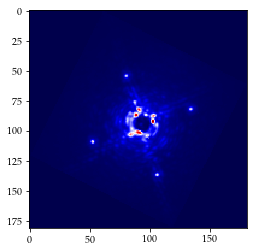

In [10]:
images = fits.open('images.fits')[0].data
mean_image = np.average(images, axis=0)
resid = images-mean_image
D = np.reshape(resid, (images.shape[0], -1)).T

U, W, VT = np.linalg.svd(D, full_matrices=False)

k = 10
lowrank = np.linalg.multi_dot([U[:, :k], np.diag(W[:k]), VT[:k]])
imapprox = np.reshape(lowrank.T, images.shape)
imapprox += mean_image
frac_var = np.cumsum(W**2)/np.sum(W**2)

plt.imshow(mean_image, cmap='seismic')
plt.show()

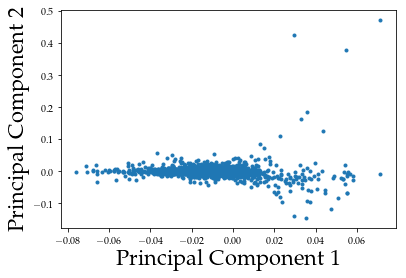

In [52]:
# Plot of the first two principal components
plt.plot(U[:, 0], U[:, 1], '.')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

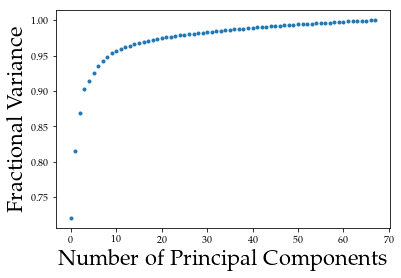

In [53]:
plt.plot(np.arange(0, np.size(frac_var)), frac_var, '.')
plt.xlabel("Number of Principal Components")
plt.ylabel("Fractional Variance")
plt.show()

> Looking at the plot of the fractional variance in terms of the number of principal components, we can see that the variance can be explained pretty well by the first 10 principal components. Beyond that point, the principal components explain less and less, so it suffices to truncate the decomposition at the 10th principal component.

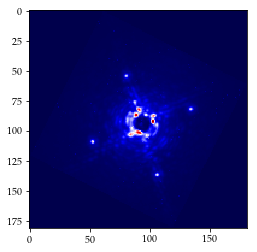

In [13]:
badpix = (np.random.uniform(0, 1, images.shape) > 0.9999)*(images != 0)
badpixval = np.std(images)*100
images += badpix*np.random.uniform(0, badpixval, images.shape)

mean_image = np.average(images, axis=0)
resid = images-mean_image
D = np.reshape(resid, (images.shape[0], -1)).T

U, W, VT = np.linalg.svd(D, full_matrices=False)
lowrank = np.linalg.multi_dot([U[:, :k], np.diag(W[:k]), VT[:k]])
imapprox = np.reshape(lowrank.T, images.shape)
imapprox += mean_image

plt.imshow(mean_image, cmap='seismic')
plt.show()

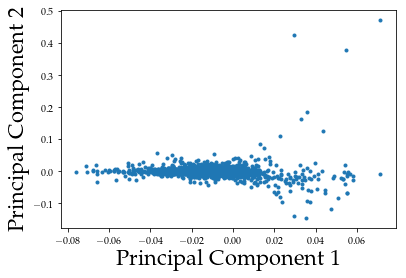

In [54]:
# Plot of the first two principal components
plt.plot(U[:, 0], U[:, 1], '.')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

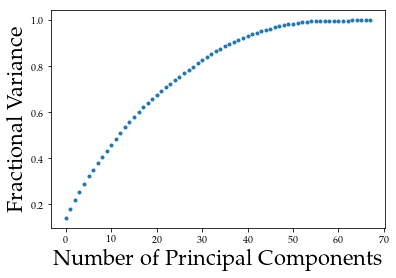

In [55]:
# To see the difference in the less significant principal components, I graphed the fractional uncertainties for this set
# of data
frac_var = np.cumsum(W**2)/np.sum(W**2)
plt.plot(np.arange(0, np.size(frac_var)), frac_var, '.')
plt.xlabel("Number of Principal Components")
plt.ylabel("Fractional Variance")
plt.show()